# Lab Instructions

You have been hired by James Cameron to create profiles of two characters for a reboot of the Titanic Movie: one that is most likely to survive the sinking and one that is least likely to survive.  Mr. Cameron wants this reboot to be as historically accurate as possible, so your profile of each character should be backed up with data and visualizations.

Each character profile should include information on their:
* Age, fare
* Sex
* Passenger class
* Travel companions (including both parents/children and siblings/spouse)
* Port of departure

For quantitative features like `Age` and `Fare`, you will need to use the `.loc` method we learned in class (or something similar) to place individuals in categories.  How you choose to do this is up to you, but make sure you explain your reasoning.

You should include at least one visualization for each element of the character profile (age, sex, passenger class, etc.) as evidence.

After you have developed your two character profiles, use your Pandas data wrangling skills to identify at least one real passenger in the dataset that fits each profile.  Print out the names of these individuals.  Look them up in [Encyclopeida Titanica](https://www.encyclopedia-titanica.org/) (or a similar resource).  

Tell Mr. Cameron at least one thing about the real passengers who fit your two character profiles that you learned from an external resource.  You need one interesting fact about a person who fits the profile of "most likely to survive" and one interesting fact about a person who fits the profile of "least likely to surivive".  



In [312]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
df = pd.read_csv('titanic_passengers.csv');


## Concerned categories:
* Age -> make into child (0-9), adolescent (10-19), adult(> 19) as defined by WHO
* Fare -> make into 4 categories, just use the percentiles...
* PClass -> 1 is upper, 2 is middle, 3 is lower
* Companions -> Parch + SibSp
* Embarked -> C is Cherbourg, Q is Queenstown, S is Southampton

We will convert the Parent/Child category to Single, Pair, and Group, because there are undeniable social consequences to these groupings. A person on their own has nobody to depend on. A pair likely has a very strong bond to be there together, and so will probably act to help each other. A group is more complex because there are many group dynamics to be considered; there is strength in numbers yes, but also hesitation and uncertain, such as diffusion of responsibility, to name one.

In [313]:

df.loc[df['Parch'] + df['SibSp'] == 0, 'Companions'] = 'Single'
df.loc[df['Parch'] + df['SibSp'] == 1, 'Companions'] = 'Pair'
df.loc[df['Parch'] + df['SibSp'] >  1, 'Companions'] = 'Group'

We will split these categories into groups of child, teen, and adult, because these are roughly how we view dependency in our society. I don't see much difference, personally, in the level of dependence between infants, toddlers, and children in the context of Titanic, because they were all likely equally hopeless. Whereas a teenager has the size, speed, and strength required to help themself and perhaps another. We will assume all unlisted ages are adults, because it seems the most accepted practice is to take the median age of the group and apply that. However, I do not wish to alter the data outside of the rows that I create, so I will let the ages be NaN to indicate that the data does not actually exist, but make those records in my own group be the same group as the median age. Since the median age is 28, we will make the default AgeGroup 'Adult'

In [314]:
df.loc[df['Age'] >= 19, 'AgeGroup'] = 'Adult'   # adult
df.loc[df['Age'] < 19, 'AgeGroup'] = 'Teen'     # adolescent
df.loc[df['Age'] <=  9, 'AgeGroup'] = 'Child'   # pre-adolescent
df['AgeGroup'] = df['AgeGroup'].fillna('Adult')                 # Default (adult)

I don't see much value in categorizing the fare when the passenger class data is available, so I am categorizing the fare in the most 'fair' way, such that each group has the same number of people.

In [315]:
df.loc[df['Fare'] <= df['Fare'].quantile(1.00), 'FareGroup'] = 'Q4'
df.loc[df['Fare'] <= df['Fare'].quantile(0.75), 'FareGroup'] = 'Q3'
df.loc[df['Fare'] <= df['Fare'].quantile(0.50), 'FareGroup'] = 'Q2'
df.loc[df['Fare'] <= df['Fare'].quantile(0.25), 'FareGroup'] = 'Q1'

# Why not put this here?
df.loc[df['Pclass'] == 1, 'Pclass_pretty'] = 'Upper'
df.loc[df['Pclass'] == 2, 'Pclass_pretty'] = 'Middle'
df.loc[df['Pclass'] == 3, 'Pclass_pretty'] = 'Lower'

df.loc[df['Survived'] == 0, 'Survived_pretty'] = 'Died'
df.loc[df['Survived'] == 1, 'Survived_pretty'] = 'Survived'


Lastly, we will populate the missing data for 'Embarked' with whichever port was most popular because it seems like most people will fill blank data with data that best represents the whole.

In [316]:
most_common_port = df['Embarked'].mode()
df['Embarked'] = df['Embarked'].fillna(most_common_port[0])

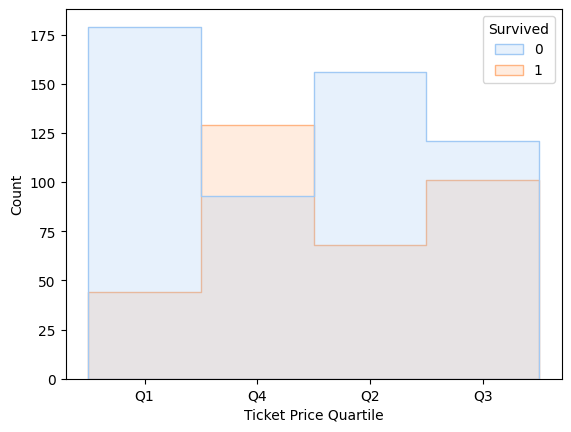

In [317]:
sns.histplot(data=df, x='FareGroup', hue='Survived', palette='pastel', element='step')
#plt.legend(['Survived', 'Died'])
plt.title = "Survivorship on the Titanic Based on Fare"
plt.xlabel('Ticket Price Quartile')
plt.xticks([0, 2, 3, 1], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.show() # I have no clue why it's not showing the title...

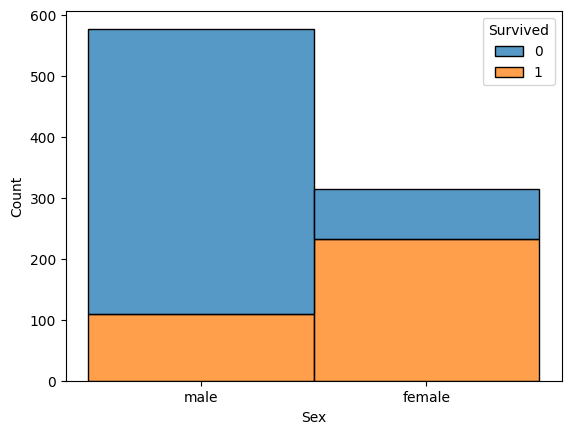

In [318]:
sns.histplot(data=df, x=df['Sex'], hue=df['Survived'], multiple='stack')
#plt.legend(['Survived', 'Died']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Sex'

plt.show();

In [327]:
print(f"{df['Fare'].quantile(.25)}-{df['Fare'].quantile(.50)}")

7.9104-14.4542
0.0


In [328]:
px.sunburst(data_frame=df, path=['Survived_pretty', 'Sex', 'Embarked', 'AgeGroup', 'Pclass_pretty', 'Companions', 'FareGroup'], width=960, height=900, labels=['Survival', 'Sex', 'Departure', 'Age', 'Ticket Class', 'Companions', 'Fare value quartile'])

I determined the majority of survivors by finding the largest group at the edge of the red in the graphic above. The majority of survivors were single, adult women departing from Southampton, who bought a middle class fare in the second quartile of values (somewhere between 7.91 and 14.45 pounds or dollars)

The majority of the dead, I got with the same process, except searching the blue. With little competition, the majority of the dead were single adult men departing from Southampton, who bought a lower class fare in the cheapest quartile of values (somewhere between 0 and 7.91)